In [268]:
%matplotlib inline
#import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; seaborn.set()
import pandas_datareader
from pandas_datareader import data as pdr
from bs4 import BeautifulSoup
import os

# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Так как продукт Б новый, возможно стоит предложить дисконт от цены Продукта А. Продукт производиться из нефти. Один из известных способов производства предполагает что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

In [247]:
# Из данных есть:
# Цены на продукт А, который уже есть на рынке Европы
# ----- октябрь 2018 - 
# ----- ноябрь 2018 - 
# ----- февраль 2019 -

# Котировки нефти, курс eur/usd
dbc = pd.read_excel('cur_oil.xlsx')

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками. 
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

        Date  EURUSD=X    OIL
0 2018-01-01    1.2005    NaN
1 2018-01-02    1.2012  59.15
2 2018-01-03    1.2063  59.15
3 2018-01-04    1.2010  59.15
4 2018-01-05    1.2069  60.44
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      346 non-null    datetime64[ns]
 1   EURUSD=X  346 non-null    float64       
 2   OIL       332 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.2 KB
1569.8256865454546
1573.073667809524
1.115


,Monty,Triangle,Stone,Poly
location,EU,CN,EU,EU
volumes,200,30,150,70
comment,moving_average,monthly,moving_average,monthly
Price,1519.834402,1700.843431,1519.834402,1587.042931


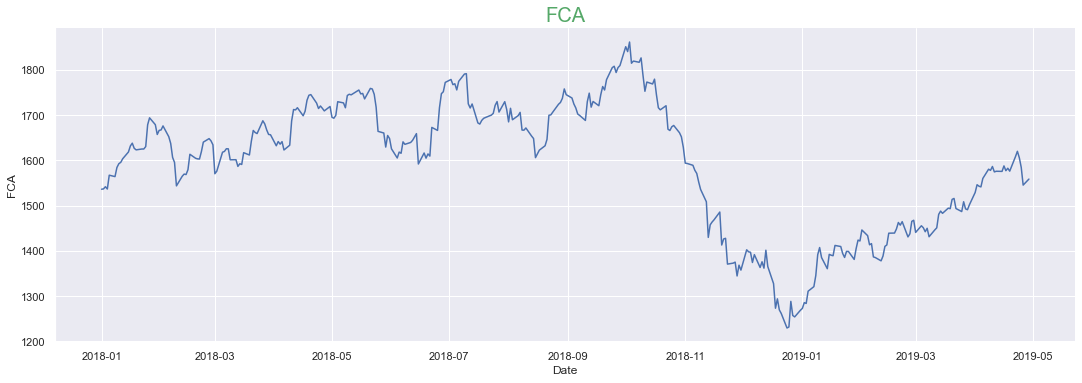

In [314]:
#1
print(dbc.head())
dbc.info()
dbc.head()

dbc_adj=dbc.fillna(method="pad").fillna(method="bfill")

#2
dbc_adj['FCA']=dbc2['OIL']*dbc2['EURUSD=X']*16+400
#3 
sns.relplot(
   
    x='Date', 
    y='FCA', 
    data=dbc2, 
    kind='line',
    aspect=3
)
plt.title('FCA', size=20, color='g');

#4
dbc_adj['Month_Year']=dbc['Date'].dt.to_period('M')

grouped=dbc_adj.groupby('Month_Year').mean()

dbc_adj['MA'] = dbc_adj['FCA'].rolling(window=22).mean()

Last_MA_price=dbc_adj['MA'].iloc[-1]
Last_EURUSD=dbc_adj['EURUSD=X'].iloc[-1]
Last_monthly_price=grouped['FCA'].iloc[-1]

for customer in customers.keys():
    if customers.get(customer).get('location')=='EU':
        customers.get(customer)['Price']=EU_LOGISTIC_COST_EUR
    else:
        customers.get(customer)['Price']=CN_LOGISTIC_COST_USD*Last_EURUSD 
    
    if customers.get(customer).get('comment')=='moving_average':
        customers.get(customer)['Price']=customers.get(customer).get('Price')+Last_MA_price
    else:
         customers.get(customer)['Price']=customers.get(customer).get('Price')+Last_monthly_price
            
    if customers.get(customer).get('volumes')<=100:
        customers.get(customer)['Price']=customers.get(customer).get('Price')*(1-discounts.get('up to 100'))
    elif customers.get(customer).get('volumes')>100 and customers.get(customer).get('volumes')<=300:
        customers.get(customer)['Price']=customers.get(customer).get('Price')*(1-discounts.get('up to 300'))    
    else:
         customers.get(customer)['Price']=customers.get(customer).get('Price')*(1-discounts.get('300 plus'))
            

        
customers_with_prices = pd.DataFrame.from_dict(customers)

print(Last_MA_price)
print(Last_monthly_price)
print(Last_EURUSD)



with pd.ExcelWriter('customers_with_prices_lesson3.xlsx', engine='xlsxwriter') as writer:
    for i in list(customers.keys()):
        pd.DataFrame.from_dict(customers_with_prices[i]).reset_index().to_excel(writer, sheet_name=i, index=False)
        

customers_with_prices.head()


# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [ ]:
# 

# Задание 3. Back to Russia

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать ВБП для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a>.


In [ ]:
# 

# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


In [ ]:
# 

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [ ]:
# import yourpackage

# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage